本小节我们将使用 RNN 完成图像说明( Image Captioning)任务。该任务需要联合 CNN 与 RNN 一同学习，CNN 用于提取图像特征，RNN 用于生成图像特征所对应的说明文字。   

在训练阶段，首先我们将图片放入卷积网络中进行特征提取，将其作为隐藏层h0的输入；然后将图片对应的文字描述一个单词接一个单词的输入到 RNN 中，而 RNN 输出则是当前单词的下一个预测单词。

在测试阶段，我们将 RNN 预测的当前单词，作为下一时间片段的输入数据输入到 RNN 中。

In [1]:
#-*- coding: utf-8 -*-
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
from classifiers.chapter7 import *
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] =(10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """相对误差"""
    return np.max(np.abs(x - y) /(np.maximum(1e-8, np.abs(x) + np.abs(y))))

### Microsoft COCO

本练习将使用2014年发布的 [Microsoft COCO dataset](http://mscoco.org/)，其作为标准的图像说明测试数据，包含有80000个训练数据以及40000验证数据，使用该网址"http://cs231n.stanford.edu/coco_captioning.zip" 下载数据集，下载完毕后解压到datasets文件目录。

该套数据集已经对数据使用VGG-16卷积网络进行了特征提取，分别存放在`train2014_vgg16_fc7.h5`和`val2014_vgg16_fc7.h5`

如果想要缩短运行时间，其也将特征从4096降到了512维，分别存放在`train2014_vgg16_fc7_pca.h5`以及`val2014_vgg16_fc7_pca.h5`中

原始图像大约有20GB，你可以使用`train2014_urls.txt`和`val2014_urls.txt`访问(需要翻墙)。

直接处理字符串非常不高效，因此我们给每个词分配了字典ID方便我们查阅使用。因此，输入的序列数据其实是一条字典ID串，该文件存放在 `coco2014_vocab.json`。你需要使用`coco_utils.py`文件中的 `decode_captions`函数将ID转换为词向量。

在训练RNN前，你需要使用记号 `<START>` 和 `<END>`标记句子的开头与结束。对于一些不常用的词我们使用`<UNK>` 进行替换。为了使句子长度相同，对于短句子，我们在 `<END>`标记后，填充`<NULL>` ，在训练时，不计算`<NULL>` 的损失与梯度。

以上内容可能过于繁杂，我们已经默默处理好了，你知道即可。


In [2]:
data = load_coco_data(pca_features=True)
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


### RNN单步前向传播

打开 `classifiers\chapter7\rnn_layers.py`文件。完成`rnn_step_forward`函数，实现RNN的单步前向传播。

完成后运行下列代码，检验你的实现。

In [3]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
    [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
    [ 0.66854692,    0.79562378,    0.87755553,    0.92795967],
    [ 0.97934501,    0.99144213,    0.99646691,    0.99854353]])

print('next_h 误差: ', rel_error(expected_next_h, next_h))

next_h 误差:  6.292421426471037e-09


### RNN单步反向传播

打开 classifiers\chapter7\rnn_layers.py文件。完成`rnn_step_backward`函数，实现RNN的单步反向传播。

完成后运行下列代码，检验你的实现。你的相对误差应该小于`1e-8`

In [4]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

# 计算前向传播后的各个值
fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx 误差: ', rel_error(dx_num, dx))
print('dprev_h 误差: ', rel_error(dprev_h_num, dprev_h))
print('dWx 误差: ', rel_error(dWx_num, dWx))
print('dWh 误差: ', rel_error(dWh_num, dWh))
print('db 误差: ', rel_error(db_num, db))

dx 误差:  1.310256557537144e-09
dprev_h 误差:  2.1172970274127977e-10
dWx 误差:  1.6514816613293213e-08
dWh 误差:  1.770717277127576e-09
db 误差:  3.152117259170483e-10


### RNN时序前向传播

现在你需要将单步RNN组合起来，实现完整的时序RNN前向传播过程

打开    `classifiers\chapter7\rnn_layers.py` ,完成 `rnn_forward`函数编码。你的相对误差应该要小于`1e-7`

In [5]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
    [
        [-0.42070749, -0.27279261, -0.11074945,    0.05740409,    0.22236251],
        [-0.39525808, -0.22554661, -0.0409454,     0.14649412,    0.32397316],
        [-0.42305111, -0.24223728, -0.04287027,    0.15997045,    0.35014525],
    ],
    [
        [-0.55857474, -0.39065825, -0.19198182,    0.02378408,    0.23735671],
        [-0.27150199, -0.07088804,    0.13562939,    0.33099728,    0.50158768],
        [-0.51014825, -0.30524429, -0.06755202,    0.17806392,    0.40333043]]])
print('h 误差: ', rel_error(expected_h, h))

h 误差:  7.728466180186066e-08


### RNN时序反向传播
现在你需要将单步RNN反向传播组合起来，实现完整的时序RNN反向传播过程

打开 `classifiers\chapter7\rnn_layers.py`    ,完成 `rnn_backward` 函数编码。

In [6]:
N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx 误差: ', rel_error(dx_num, dx))
print('dh0 误差: ', rel_error(dh0_num, dh0))
print('dWx 误差: ', rel_error(dWx_num, dWx))
print('dWh 误差: ', rel_error(dWh_num, dWh))
print('db 误差: ', rel_error(db_num, db))

dx 误差:  3.019690437635004e-09
dh0 误差:  2.1293713568630968e-10
dWx 误差:  1.227642349941746e-09
dWh 误差:  1.8455612502078363e-09
db 误差:  1.347211901044371e-10


### 词嵌入前向传播

现在，需要将时序数据（索引串）转换为词向量。

打开 `classifiers\chapter7\rnn_layers.py`文件，实现 `word_embedding_forward`函数，将单词索引，转化为词向量。

运行下列代码，你的实现误差大约在范围`1e-8`

In [7]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,                    0.07142857,    0.14285714],
    [ 0.64285714,    0.71428571,    0.78571429],
    [ 0.21428571,    0.28571429,    0.35714286],
    [ 0.42857143,    0.5,                 0.57142857]],
 [[ 0.42857143,    0.5,                 0.57142857],
    [ 0.21428571,    0.28571429,    0.35714286],
    [ 0.,                    0.07142857,    0.14285714],
    [ 0.64285714,    0.71428571,    0.78571429]]])

print('out 误差: ', rel_error(expected_out, out))

out 误差:  1.0000000094736443e-08


### 词嵌入反向传播
实现 `word_embedding_backward`函数，完成词嵌入的反向传播。

运行下列梯度检验代码，你的误差应该小于`1e-11`

In [8]:
N, T, V, D = 50, 3, 5, 6

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW 误差: ', rel_error(dW, dW_num))

dW 误差:  3.2759708946363888e-12


### 时序输出仿射层

RNN隐藏层到输出层传播和前馈网络类似，只是其数据为(N,T,D)的三维数据。

我们已经将其前向传播，反向传播分别实现在了`temporal_affine_forward`和 `temporal_affine_backward`函数中。

打开`rnn_layers.py`文件，阅读相关代码，并运行下列代码进行检验

In [9]:
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

dx 误差:  1.1680190237299396e-09
dw 误差:  1.195903277097059e-11
db 误差:  1.0561424698310812e-11


### 时序Softmax损失函数

在使用RNN进行语言建模时，每一时间步我们都会预测下一个单词对应单词字典中的单词得分索引。每一时间片段我们使用softmax作为损失函数，而整个序列的损失值，我们是将每一时间片段的损失值加起来取平均值。但句子的长度是不相同的，为了使输入对齐，我们填充`<NULL>`补全短句子。但这些填充的 `<NULL>`标记不应该计算在损失值或梯度值内，我们需要使用 `mask`进行过滤。我们已经将其写进`rnn_layers.py`文件中的 `temporal_softmax_loss` 函数，阅读即可。

In [10]:
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
    
check_loss(100, 1, 10, 1.0)     # 损失值大约为 2.3
check_loss(100, 10, 10, 1.0)    # 损失值大约为 23
check_loss(5000, 10, 10, 0.1) # 损失值大约为 2.3

N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask =(np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(
        lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx 误差: ', rel_error(dx, dx_num))

2.302582382261073
23.02576008490865
2.34310410100737
dx 误差:  5.811536038658937e-08


## RNN图像说明任务

我们已经实现了我所需的各项零件，接下来我们就用RNN完成图片说明任务。打开`rnn.py`文件，阅读`CaptioningRNN`类。你需要实现RNN的`loss`函数，以及测试阶段使用的`sample`函数。目前你只需实现`cell_type = 'rnn'`即可，之后再实现LSTM部分内容。

完成后运行下列代码，你的损失误差应该小于 `1e-10`

In [11]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
                    input_dim=D,
                    wordvec_dim=W,
                    hidden_dim=H,
                    cell_type='rnn')

for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions =(np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('损失: ', loss)
print('期望损失: ', expected_loss)
print('误差: ', abs(loss - expected_loss))

损失:  9.832355910027388
期望损失:  9.83235591003
误差:  2.611244553918368e-12


 `CaptioningRNN` 梯度检验，期望误差在 `1e-7` 

In [12]:
batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size,
                                                                                             timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
                    input_dim=input_dim,
                    wordvec_dim=wordvec_dim,
                    hidden_dim=hidden_dim,
                    cell_type='rnn'
                )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], 
                         verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s 相对误差: %e' %(param_name, e))

W_embed 相对误差: 4.599221e-09
W_proj 相对误差: 5.548484e-09
W_vocab 相对误差: 3.479308e-08
Wh 相对误差: 1.954925e-08
Wx 相对误差: 8.715990e-06
b 相对误差: 2.182615e-09
b_proj 相对误差: 4.525645e-09
b_vocab 相对误差: 1.879290e-09


### 过拟合小量数据

(Iteration 1 / 100) loss: 87.278615
(Iteration 11 / 100) loss: 24.241030
(Iteration 21 / 100) loss: 6.001595
(Iteration 31 / 100) loss: 1.049757
(Iteration 41 / 100) loss: 0.638685
(Iteration 51 / 100) loss: 0.245997
(Iteration 61 / 100) loss: 0.199264
(Iteration 71 / 100) loss: 0.145133
(Iteration 81 / 100) loss: 0.130924
(Iteration 91 / 100) loss: 0.118513


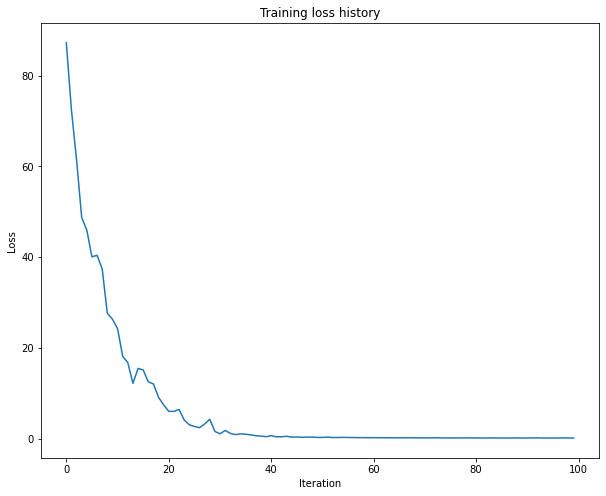

In [13]:
small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
                    cell_type='rnn',
                    word_to_idx=data['word_to_idx'],
                    input_dim=data['train_features'].shape[1],
                    hidden_dim=512,
                    wordvec_dim=256,
                )

small_rnn_solver = CaptioningTrainer(small_rnn_model, small_data,
                     update_rule='adam',
                     num_epochs=50,
                     batch_size=25,
                     updater_config={
                         'learning_rate': 5e-3,
                     },
                     lr_decay=0.95,
                     verbose=True, print_every=10,
                 )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

## LSTM

### LSTM单步前向传播

打开 `rnn_layers.py`文件，完成lstm_step_forward代码，实现LSTM的单步前向传播。

运行下列代码，你的实现误差应该在` 1e-8`以内。

In [14]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
        [ 0.24635157,    0.28610883,    0.32240467,    0.35525807,    0.38474904],
        [ 0.49223563,    0.55611431,    0.61507696,    0.66844003,    0.7159181 ],
        [ 0.56735664,    0.66310127,    0.74419266,    0.80889665,    0.858299    ]])
expected_next_c = np.asarray([
        [ 0.32986176,    0.39145139,    0.451556,        0.51014116,    0.56717407],
        [ 0.66382255,    0.76674007,    0.87195994,    0.97902709,    1.08751345],
        [ 0.74192008,    0.90592151,    1.07717006,    1.25120233,    1.42395676]])

print('next_h 误差: ', rel_error(expected_next_h, next_h))
print('next_c 误差: ', rel_error(expected_next_c, next_c))

next_h 误差:  5.7054131185818695e-09
next_c 误差:  5.8143123088804145e-09


### LSTM:单步反向传播

打开 rnn_layers.py文件，完成lstm_step_backward函数代码，实现LSTM的单步反向传播。

运行下列代码，你的期望误差应该在1e-8以内

In [15]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx 误差: ', rel_error(dx_num, dx))
print('dh 误差: ', rel_error(dh_num, dh))
print('dc 误差: ', rel_error(dc_num, dc))
print('dWx 误差: ', rel_error(dWx_num, dWx))
print('dWh 误差: ', rel_error(dWh_num, dWh))
print('db 误差: ', rel_error(db_num, db))

dx 误差:  2.36114504649104e-10
dh 误差:  5.784107694134561e-10
dc 误差:  6.99069012739093e-10
dWx 误差:  6.291017711941009e-08
dWh 误差:  4.4809579254128135e-09
db 误差:  2.551473660645273e-10


### LSTM前向传播

现在将单步传播组合起来，完成完整的时序传播。打开`rnn_layers.py` 文件，完成`lstm_forward`函数代码，实现LSTM的前向传播。

运行下列代码，你的实现误差应该在1e-7以内

In [16]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,    0.01823233,    0.01882671,    0.0194232 ],
    [ 0.11287491,    0.12146228,    0.13018446,    0.13902939],
    [ 0.31358768,    0.33338627,    0.35304453,    0.37250975]],
 [[ 0.45767879,    0.4761092,     0.4936887,     0.51041945],
    [ 0.6704845,     0.69350089,    0.71486014,    0.7346449 ],
    [ 0.81733511,    0.83677871,    0.85403753,    0.86935314]]])

print('h 误差: ', rel_error(expected_h, h))

h 误差:  8.610537452106624e-08


### LSTM反向传播

现在将单步反向传播组合起来，完成完整的时序反向传播。打开`rnn_layers.py` 文件，完成`lstm_backward` 函数代码，实现LSTM的反向传播。

运行下列代码。你的误差大约在`1e-8` 

In [17]:

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx 误差: ', rel_error(dx_num, dx))
print('dh0 误差: ', rel_error(dx_num, dx))
print('dWx 误差: ', rel_error(dx_num, dx))
print('dWh 误差: ', rel_error(dx_num, dx))
print('db 误差: ', rel_error(dx_num, dx))

dx 误差:  7.278901660157261e-10
dh0 误差:  7.278901660157261e-10
dWx 误差:  7.278901660157261e-10
dWh 误差:  7.278901660157261e-10
db 误差:  7.278901660157261e-10


### LSTM图片说明任务

打开`rnn.py`文件，完成LSTM模式下的损失计算。

In [18]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
                    input_dim=D,
                    wordvec_dim=W,
                    hidden_dim=H,
                    cell_type='lstm')

for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions =(np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('损失值: ', loss)
print('期望损失值: ', expected_loss)
print('误差: ', abs(loss - expected_loss))

损失值:  9.82445935443226
期望损失值:  9.82445935443
误差:  2.261302256556519e-12


###    LSTM 过拟合测试

和RNN类似，我们测试LSTM能否在小数据集上过拟合

(Iteration 1 / 100) loss: 77.184947
(Iteration 11 / 100) loss: 39.224173
(Iteration 21 / 100) loss: 26.396812
(Iteration 31 / 100) loss: 14.473610
(Iteration 41 / 100) loss: 4.766169
(Iteration 51 / 100) loss: 1.583464
(Iteration 61 / 100) loss: 1.577735
(Iteration 71 / 100) loss: 0.271194
(Iteration 81 / 100) loss: 0.206668
(Iteration 91 / 100) loss: 0.110635


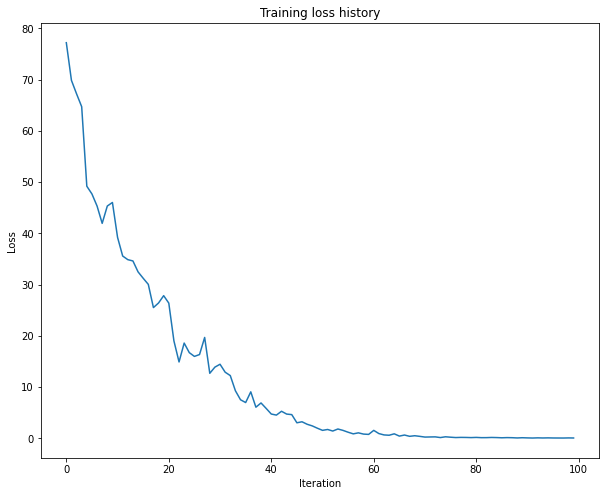

In [19]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
                    cell_type='lstm',
                    word_to_idx=data['word_to_idx'],
                    input_dim=data['train_features'].shape[1],
                    hidden_dim=512,
                    wordvec_dim=256)

small_lstm_solver = CaptioningTrainer(small_lstm_model, small_data,
                     update_rule='adam',
                     num_epochs=50,
                     batch_size=25,
                     updater_config={
                         'learning_rate': 5e-3,
                     },
                     lr_decay=0.995,
                     verbose=True, print_every=10,
                 )

small_lstm_solver.train()

plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### LSTM test-time sampling

http://farm7.staticflickr.com/6178/6167892245_3ef7bfd6c2_z.jpg


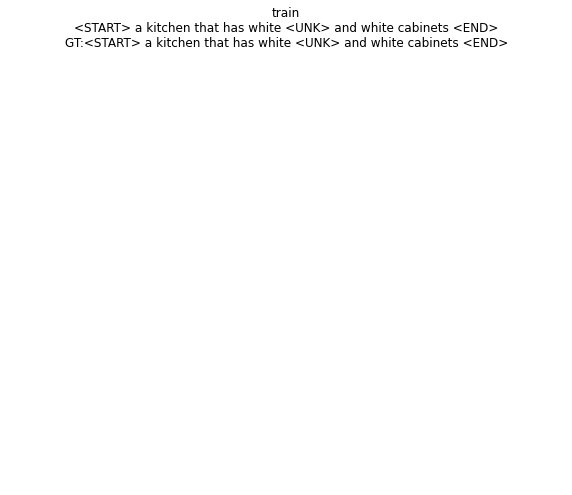

http://farm5.staticflickr.com/4121/4769212854_0bcba64aa7_z.jpg


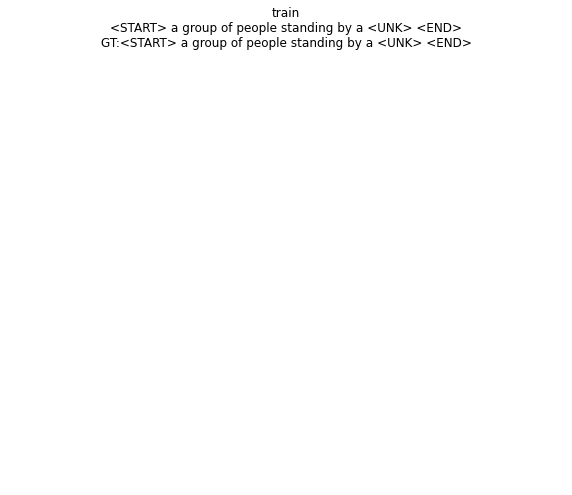

http://farm2.staticflickr.com/1112/596804848_afb6e350a8_z.jpg


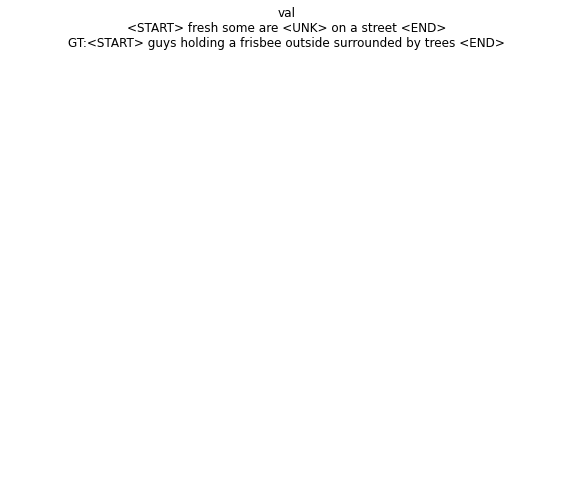

http://farm1.staticflickr.com/164/439147986_2486920a79_z.jpg


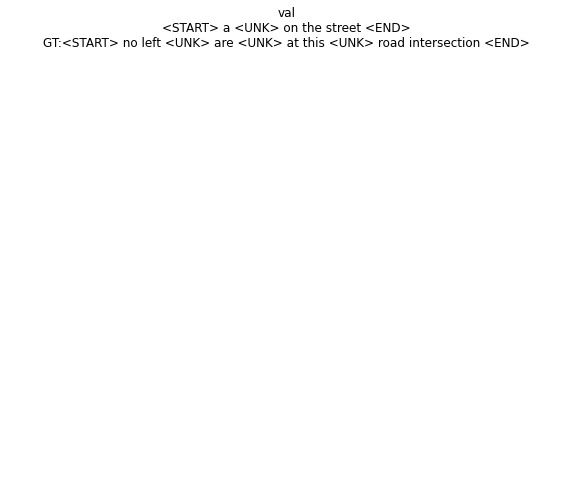

In [20]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        # plt.imshow(image_from_url(url))
        print(url)
        plt.title('%s\n%s\nGT:%s' %(split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

### 训练一个好的图片说明任务

(Iteration 1 / 2500) loss: 77.557809
(Iteration 51 / 2500) loss: 41.835524
(Iteration 101 / 2500) loss: 35.659107
(Iteration 151 / 2500) loss: 33.714988
(Iteration 201 / 2500) loss: 30.808365
(Iteration 251 / 2500) loss: 28.904012
(Iteration 301 / 2500) loss: 26.059836
(Iteration 351 / 2500) loss: 26.031326
(Iteration 401 / 2500) loss: 22.815424
(Iteration 451 / 2500) loss: 22.772759
(Iteration 501 / 2500) loss: 20.736977
(Iteration 551 / 2500) loss: 21.022939
(Iteration 601 / 2500) loss: 19.118450
(Iteration 651 / 2500) loss: 18.663928
(Iteration 701 / 2500) loss: 16.895750
(Iteration 751 / 2500) loss: 16.610176
(Iteration 801 / 2500) loss: 16.800854
(Iteration 851 / 2500) loss: 15.282215
(Iteration 901 / 2500) loss: 13.853283
(Iteration 951 / 2500) loss: 12.862395
(Iteration 1001 / 2500) loss: 12.577979
(Iteration 1051 / 2500) loss: 11.035210
(Iteration 1101 / 2500) loss: 11.835750
(Iteration 1151 / 2500) loss: 11.085219
(Iteration 1201 / 2500) loss: 10.444645
(Iteration 1251 / 2500)

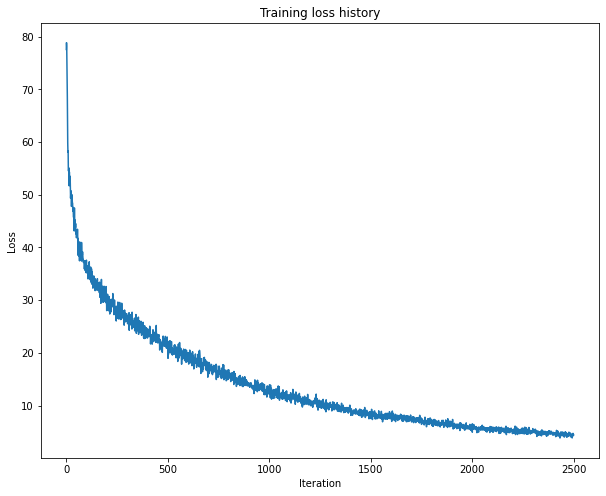

In [21]:
#pass
small_data2 = load_coco_data(max_train=5000)
good_lstm_model = CaptioningRNN(
                    cell_type='lstm',
                    word_to_idx=data['word_to_idx'],
                    input_dim=data['train_features'].shape[1],
                    hidden_dim=200,
                    wordvec_dim=256 )

good_lstm_solver = CaptioningTrainer(good_lstm_model, small_data2,
                     update_rule='adam',
                     num_epochs=50,
                     batch_size=100,
                     updater_config={
                         'learning_rate': 5e-3,
                     },
                     lr_decay=0.995,
                     verbose=True, print_every=50,
                 )

good_lstm_solver.train()

plt.plot(good_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

http://farm9.staticflickr.com/8102/8510027814_acffff06cd_z.jpg


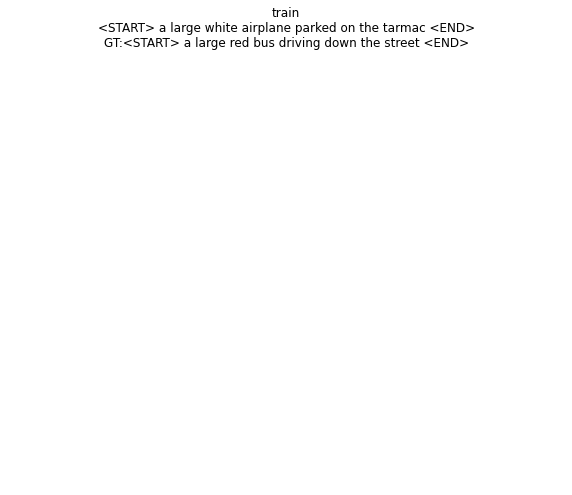

http://farm8.staticflickr.com/7035/6510880243_4086cbb06e_z.jpg


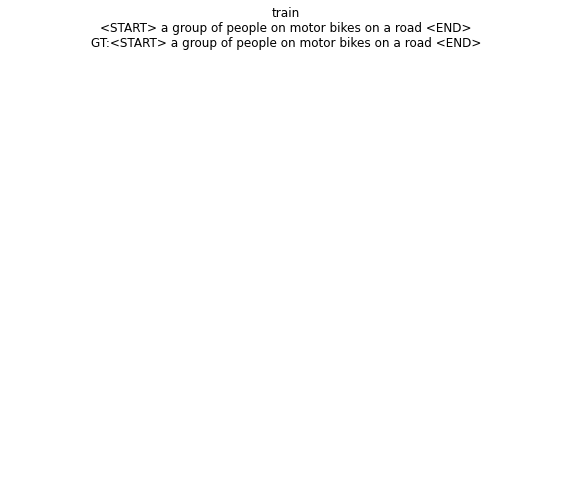

http://farm6.staticflickr.com/5328/9362192917_5324bd3d74_z.jpg


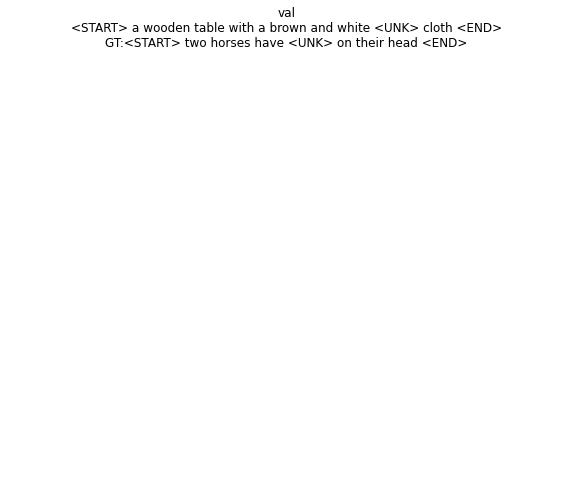

http://farm4.staticflickr.com/3316/5816070088_dfdce60093_z.jpg


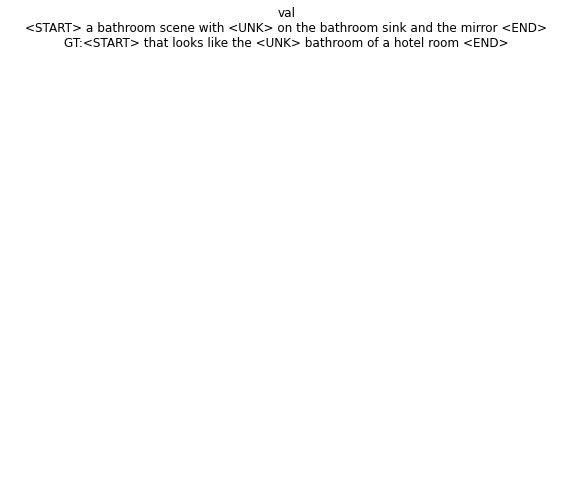

In [23]:
#pass
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data2, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = good_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        #plt.imshow(image_from_url(url))
        print(url)
        plt.title('%s\n%s\nGT:%s' %(split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()